# Data Setup

## I. Import database

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

db_file = 'db1.sqlite3'
conn = sqlite3.connect(db_file)
c = conn.cursor()

## II. Define functions

In [2]:
# use this function to return a value from a query
def query_db(statement):
    return c.execute(statement).fetchall()[0][0]

# use this function to list all column names for a given table
def col_names(table):
    statement = "PRAGMA table_info({})".format(table)
    return c.execute(statement).fetchall()

# use this function to return a dataframe from a query
def create_df(statement):
    return pd.read_sql_query(statement, conn)

In [3]:
query_db('select count(*) from people_person where date_joined < "2018-02-03"')

35826

In [4]:
col_names('people_person')

[(0, 'id', 'integer', 1, None, 1),
 (1, 'first_name', 'varchar(30)', 1, None, 0),
 (2, 'last_name', 'varchar(30)', 1, None, 0),
 (3, 'email', 'varchar(100)', 1, None, 0),
 (4, 'channel', 'varchar(20)', 1, None, 0),
 (5, 'date_joined', 'datetime', 1, None, 0),
 (6, 'photo', 'varchar(200)', 1, None, 0),
 (7, 'fee', 'decimal', 1, None, 0),
 (8, 'gender', 'varchar(1)', 1, None, 0)]

In [5]:
create_df('select * from people_person where date_joined < "2018-02-03" limit 5')

,id,first_name,last_name,email,channel,date_joined,photo,fee,gender
0,1,Leanora,Allcock,leanora.allcock635@hotmail.com,,2016-08-02 14:59:15.095591,https://placekitten.com/242/269,0,f
1,2,Elroy,Blanding,elroy.blanding510@yahoo.com,,2016-08-02 18:15:30.105940,https://placekitten.com/373/320,0,m
2,3,Jeanice,Aleman,jeanice.aleman392@hotmail.com,,2016-08-02 16:11:09.542004,https://placekitten.com/238/264,0,f
3,4,Tamala,Polhamus,tamala.polhamus146@aol.com,,2016-08-02 18:02:40.389299,https://placekitten.com/220/223,0,f
4,5,Alethea,Gubler,alethea.gubler708@aol.com,,2016-08-02 14:31:53.163034,https://placekitten.com/284/339,0,f


# Questions

## II. Conversations and Bookings

In [6]:
# determine columns
col_names('conversations_review')

[(0, 'id', 'integer', 1, None, 1),
 (1, 'content', 'varchar(500)', 1, None, 0),
 (2, 'stars', 'smallint unsigned', 1, None, 0),
 (3, 'conversation_id', 'integer', 1, None, 0),
 (4, 'reviewer_id', 'integer', 1, None, 0)]

In [7]:
# create review datframe
review_df = create_df('''select stars, reviewer_id, requester_id from conversations_review as review
                      left join conversations_conversation as conv on review.conversation_id = conv.id''')

In [8]:
# distribution of reviewers
review_results = pd.DataFrame(columns=['user_type', 'share_of_total_reviews', 'average_review'])

# owners
owner_share = len(review_df[review_df['reviewer_id'] == review_df['requester_id']])/len(review_df)
owner_review_avg = review_df.loc[review_df['reviewer_id'] == review_df['requester_id'], 'stars'].mean()
review_results = review_results.append({'user_type':'owner','share_of_total_reviews':owner_share,
                                        'average_review':owner_review_avg},ignore_index=True)

# provider
provider_share = len(review_df[review_df['reviewer_id'] != review_df['requester_id']])/len(review_df)
provider_review_avg = review_df.loc[review_df['reviewer_id'] != review_df['requester_id'], 'stars'].mean()
review_results = review_results.append({'user_type':'provider','share_of_total_reviews':provider_share,
                                        'average_review':provider_review_avg},ignore_index=True)

In [9]:
review_results

,user_type,share_of_total_reviews,average_review
0,owner,0.787753,4.415841
1,provider,0.212247,3.904817


### The results table above shows that pet owners provide about 79% of all reviews, close to four times more reviews than providers. Additionally, owners leave higher average reviews than providers (4.42 compared to 3.90).

### I would narrate this finding to a business partner by noting the figures above, as well as the sample size used to create these summary statistics. This is a fairly large sample so we can conclude that it's likely that there is an underlying trend in this data. If the business partner is interested in figuring out why these large differences exist, I would break these results down further to see the effect that pet type, service type, location, or other factors might have on the reviews.

## IV. Analyzing Take Rate

In [59]:
# create billing datframe
billings_df = create_df('''select requester_id, booked_at, strftime("%Y-%m", booked_at) as booking_month,
                              booking_total, people.fee as owner_fee, service.fee as service_fee
                              from conversations_conversation as conv
                              left join people_person as people on conv.requester_id = people.id
                              left join services_service as service on conv.service_id = service.id
                              where booked_at != "None" and cancelled_at is null''')

In [60]:
# add columns
billings_df['owner_fee_dollars'] = billings_df['booking_total'] * billings_df['owner_fee']
billings_df['gross_bill'] = billings_df['booking_total'] + billings_df['owner_fee_dollars']
billings_df['service_fee_dollars'] = billings_df['booking_total'] * billings_df['service_fee']
billings_df['net_revenue'] = billings_df['owner_fee_dollars'] + billings_df['service_fee_dollars']


# group by month
billing_table = billings_df.groupby(['booking_month'])[['gross_bill', 'net_revenue']].sum().reset_index()

# add take rate
billing_table['take_rate'] = billing_table['net_revenue'] / billing_table['gross_bill']

,booking_month,gross_bill,net_revenue,take_rate
0,2016-08,3810.72,635.12,0.166667
1,2016-09,16478.10,2746.35,0.166667
2,2016-10,28833.36,4805.56,0.166667
3,2016-11,38414.22,6402.37,0.166667
4,2016-12,51103.98,8575.93,0.167813
5,2017-01,69952.14,12943.49,0.185034
6,2017-02,82967.76,15410.61,0.185742
7,2017-03,115218.81,21550.51,0.187040
8,2017-04,122019.60,22890.05,0.187593
9,2017-05,150345.78,28323.93,0.188392


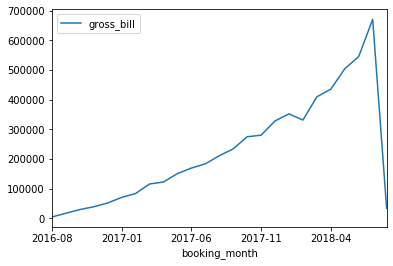

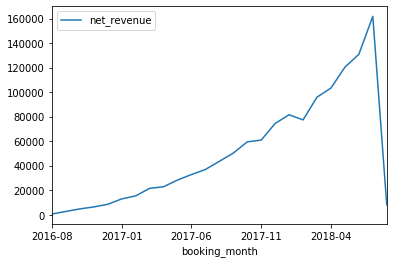

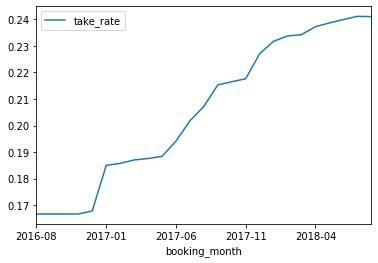

In [82]:
billing_table.plot(kind='line', x='booking_month', y='gross_bill')
billing_table.plot(kind='line', x='booking_month', y='net_revenue')
billing_table.plot(kind='line', x='booking_month', y='take_rate')

billing_table

### The table and plots show the gross billings, net revenue, and take rate for each month starting in August 2016 through August 2018. All three values have been steadily increasing over time.

### In order to determine why these values have been increasing, we can look at the component parts that make up these values. Take rate is a function of net revenue and gross billings, and those are in turn made up of the booking total, owner fees, and service fees.

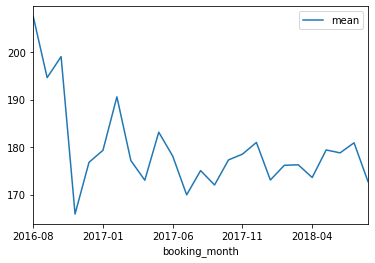

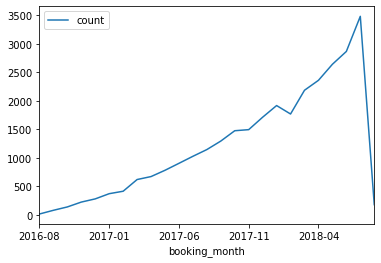

In [66]:
# group booking_total by month
booking_table = billings_df.groupby(['booking_month'])['booking_total'].agg(['sum','mean','count']).reset_index()
booking_table.plot(kind='line', x='booking_month', y='mean')
booking_table.plot(kind='line', x='booking_month', y='count')

### Booking totals are closely related to gross bill totals, so it makes sense that they are trending upwards together. A closer examination indicates that booking totals are increasing due to higher volume of customers, not increased spending on each booking. The first graph shows a fluctuating average booking total, but typically it's in a fairly narrow range between 170 and 200 per booking. The second graph shows the number of individual bookings made each month, which seems to be the primary cause of increased monthly booking totals and gross billing totals. This second graph is very similar to the gross bills and net revenue graphs above.

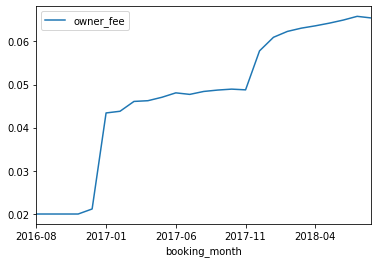

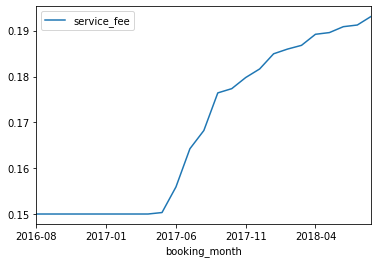

In [67]:
# group fees by month
fees_table = billings_df.groupby(['booking_month'])[['owner_fee', 'service_fee']].mean().reset_index()
fees_table.plot(kind='line', x='booking_month', y='owner_fee')
fees_table.plot(kind='line', x='booking_month', y='service_fee')

### However, increased booking totals does not explain the increase in take rate. Gross bills and net revenue could be steadily increasing because of an increase in customers, but if that's the only variable that changes, then we would expect the take rate to be the same each month. The two graphs above show that the average owner fees and service fees have also been increasing over time. Both experienced big jumps that allowed the company to charge higher fees and thus take in a larger share of the average gross bill totals. As long as these two fee percentages continue to increase, I would expect that the take rate will also keep increasing, allowing the company to be more profitable. 

## VI. Search Engine Marketing 

,index,date_joined
0,2016-08-08,1
1,2016-08-09,1
2,2016-08-10,1
3,2016-08-11,1
4,2016-08-12,1
...,...,...
700,2018-07-28,73
701,2018-07-29,65
702,2018-07-30,86
703,2018-07-31,87


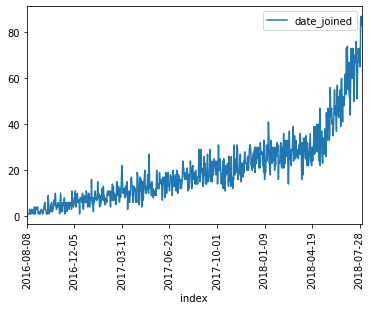

In [56]:
# create people df
people_df = create_df('''select strftime("%Y-%m-%d", date_joined) as date_joined from people_person
                         where channel = "Google"''')

# create signup table
signup_table = people_df['date_joined'].value_counts().reset_index().sort_values(by=['index']).reset_index(drop=True)

signup_table.plot(kind='line', x='index', y='date_joined')
plt.xticks(rotation=90)

signup_table

(array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225.]),
 <a list of 10 Text xticklabel objects>)

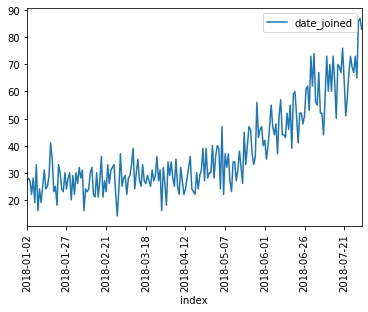

In [55]:
# plot smaller window to see inflection point
small_table = signup_table[signup_table['index'] > '2018-01-01']
small_table.plot(kind='line', x='index', y='date_joined')
plt.xticks(rotation=90)

### The table and graphs above show daily signups from Google for the company. Signups have been trending up since the beginning, but the bottom graph clearly shows an increase in daily signups around early May.

In [77]:
# look at signups since May 4th
recent_table = signup_table[signup_table['index'] >= '2018-05-04']

# total users joined since increased advertising
total_user_growth = recent_table['date_joined'].sum()
print(total_user_growth)

# average cost per user since increased advertising
total_spend = 207180
avg_user_cost = total_spend/total_user_growth
print(avg_user_cost)

4604
45.0


### The summary statistics above show that 4604 users have signed up since the increase in adversiting on May 4th. The average spend per user acquisition is 45 dollars. 

In [78]:
# determining average user growth before switching ad strategies
pre_switch_table = signup_table[(signup_table['index'] >= '2018-01-01') & (signup_table['index'] < '2018-05-04')]

pre_switch_growth = pre_switch_table['date_joined'].sum()/len(pre_switch_table)

# multiply by number of days since switch to get expected users with old strategy
alternate_user_growth = pre_switch_growth * len(recent_table)
print(alternate_user_growth)

# multiply by $30 per user to estimate total spend with old strategy
avg_spend = 30
alternate_total_spend = alternate_user_growth * avg_spend
print(alternate_total_spend)

2503.9024390243903
75117.07317073172


### The calculations above show that under the old strategy, we would have expected to see about 2500 new users at an estimated cost of about 75 thousand dollars (compared to 4604 users at a cost of 207 thousand dollars).

In [80]:
# calculate additional users and their marginal cost
additional_users = total_user_growth - round(alternate_user_growth, 0)
print(additional_users)

marginal_cost = (total_spend - alternate_total_spend)/additional_users
print(marginal_cost)

2100.0
62.88710801393728


### The new advertising strategy brought in an estimated 2100 additional users, but the marginal cost for each of those additional users was nearly 63 dollars. 

In [83]:
conn.close()